In [1]:
from larcv import larcv
larcv.load_pyutil
larcv.load_cvutil

import cv2
import ROOT
from ROOT import fcllite
from ROOT import geo2d
from ROOT import larocv

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

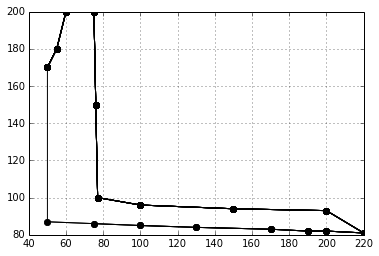

In [2]:

# make a fake image...
a=np.zeros((450,450))

ctor = ROOT.std.vector(ROOT.cv.Point_('int'))()

# make some lines
line1 = geo2d.Line("float")(50,50,-45)
line2 = geo2d.Line("float")(50,50,45)

ctor.clear()
    
pt_x=[]
pt_y=[]
#ctor.push_back(ROOT.cv.Point_("int")(20,100))
#ctor.push_back(ROOT.cv.Point_("int")(30,140))
ctor.push_back(ROOT.cv.Point_("int")(50,170))
ctor.push_back(ROOT.cv.Point_("int")(55,180))
ctor.push_back(ROOT.cv.Point_("int")(60,200))
ctor.push_back(ROOT.cv.Point_("int")(75,200))
ctor.push_back(ROOT.cv.Point_("int")(76,150))
ctor.push_back(ROOT.cv.Point_("int")(77,100))
ctor.push_back(ROOT.cv.Point_("int")(100,96))
ctor.push_back(ROOT.cv.Point_("int")(150,94))
ctor.push_back(ROOT.cv.Point_("int")(200,93))
ctor.push_back(ROOT.cv.Point_("int")(220,81))
ctor.push_back(ROOT.cv.Point_("int")(200,82))
ctor.push_back(ROOT.cv.Point_("int")(190,82))
ctor.push_back(ROOT.cv.Point_("int")(170,83))
ctor.push_back(ROOT.cv.Point_("int")(130,84))
ctor.push_back(ROOT.cv.Point_("int")(100,85))
ctor.push_back(ROOT.cv.Point_("int")(75,86))
ctor.push_back(ROOT.cv.Point_("int")(50,87))

ctor.push_back(ctor[0])
for pt in ctor:
    pt_x.append(pt.x)
    pt_y.append(pt.y)
    plt.plot(pt_x,pt_y,'o-',color='black',lw=1)

plt.grid()
plt.show()

# make a path representing this contour
path_list1 = []
path_list2 = []
path_list3 = []
for pt in ctor:
    path_list1.append((pt.x,pt.y)) 
    path_list2.append((pt.x,pt.y+100))
    path_list3.append((pt.x+100,pt.y))

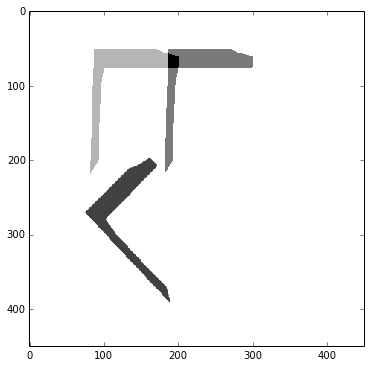

In [3]:
path1 = matplotlib.path.Path(path_list1)
path2 = matplotlib.path.Path(path_list2)
path3 = matplotlib.path.Path(path_list3)

img1 = path1.contains_points(np.row_stack(np.where(a==0)).T).reshape(450,450).astype(np.uint8)
img2 = path2.contains_points(np.row_stack(np.where(a==0)).T).reshape(450,450).astype(np.uint8)
img3 = path3.contains_points(np.row_stack(np.where(a==0)).T).reshape(450,450).astype(np.uint8)

#set img1 values to be 20
img1=np.where(img1>0,img1+40,0)
#set img1 values to be 40
img2=np.where(img2>0,img2+60,0)
#set img2 values to be 60
img3=np.where(img3>0,img3+80,0)

#rotate 3
M = cv2.getRotationMatrix2D((450/2,450/2),45,1)
img3 = cv2.warpAffine(img3,M,(450,450))

#add them...
img = img1+img2+img3

plt.imshow(img,cmap='Greys',interpolation='none')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()

In [4]:
iom = larcv.IOManager(larcv.IOManager.kWRITE)
iom.set_verbosity(0)
iom.set_out_file("/tmp/aho.root")
iom.initialize()
fake_evimg=iom.get_data(larcv.kProductImage2D,"test")
fake_evimg.Append(larcv.as_image2d(img))
iom.set_id(0,0,1)
iom.save_entry()
iom.finalize()

In [5]:
proc = larcv.ProcessDriver("ProcessDriver")
proc.configure('vertex_seeds_unit.fcl')
f=ROOT.std.string("/tmp/aho.root")
flist=ROOT.std.vector('string')()
flist.push_back(f)
proc.override_input_file(flist)
proc.initialize()
larbysimg = proc.process_ptr(0)

TypeError: none of the 2 overloaded methods succeeded. Full details:
  void larcv::ProcessDriver::configure(const string config_file) =>
    problem in C++; program state has been reset
  void larcv::ProcessDriver::configure(const larcv::PSet& cfg) =>
    could not convert argument 1

In [ ]:
proc.batch_process(0,1)

In [ ]:
mgr=larbysimg.Manager()
img_v = []
pygeo   = geo2d.PyDraw()

In [ ]:
plane=0
for mat in mgr.InputImages():
    img_v.append(pygeo.image(mat))
    shape_img=np.where(img_v[plane]>0.0,1.0,0.0).astype(np.uint8)
    fig,ax=plt.subplots(figsize=(12,12),facecolor='w')
    plt.imshow(shape_img,cmap='Greys',interpolation='none')
    plt.xlabel('Time [6 ticks]',fontsize=20)
    plt.ylabel('Wire [2 wires]',fontsize=20)
    plt.tick_params(labelsize=20)
    ax.set_aspect(0.8)
    plt.tight_layout()
    plt.show()
    plane+=1

In [ ]:
colors=['red','green','blue','orange','magenta','cyan','pink']
colors*=10
plane=0
print 'Plane',plane
fig,ax=plt.subplots(figsize=(12,12),facecolor='w')

shape_img = img_v[plane]
shape_img=np.where(img_v[plane]>0.0,1.0,0.0).astype(np.uint8)
plt.imshow(shape_img,cmap='Greys',interpolation='none')
nz_pixels=np.where(shape_img>0.0)

dm=mgr.DataManager()
data=dm.Data(0)

ix=0

vertex_seeds = data.harvest_seeds(0)
cluscomp_v = vertex_seeds.get_compounds()

#plot the atomics
for cluscomp_id in xrange(cluscomp_v.size()):
    cluscomp = cluscomp_v[cluscomp_id]
    for atomic_id in xrange(cluscomp.size()):
        atomic = cluscomp[atomic_id]
        pts=[[atomic[p_id].x,atomic[p_id].y] for p_id in xrange(atomic.size())]
        pts.append(pts[0])
        pts=np.array(pts)
        plt.plot(pts[:,0],pts[:,1],'-o',lw=5,color=colors[ix])
        ix+=1


points = data.harvest_seed_points(0)
pts_v = np.array([[points[i].x,points[i].y] for i in xrange(points.size())])

plt.plot(pts_v[:,0],pts_v[:,1],'*',markersize=30,color='yellow')
        
ax.set_aspect(1.0)
plt.tight_layout()
ax.set_ylim(np.min(nz_pixels[0])-10,np.max(nz_pixels[0])+10)
ax.set_xlim(np.min(nz_pixels[1])-10,np.max(nz_pixels[1])+10)
plt.xlabel('Time [6 ticks]',fontsize=20)
plt.ylabel('Wire [2 wires]',fontsize=20)
plt.tick_params(labelsize=20)
ax.set_aspect(0.8)
ax.text(150,300,"Yellow == Defect Seed\nOrange == PCA Seed",fontsize=30,fontweight='bold')
plt.show()